<h1> LongRunMIP_ECS_estimation: description </h1>

This Jupyter Notebook can be used to perform estimation of the equilibrium warming of transient warming simulations. It has been written for use on abrupt-4xCO2 experiments of models participating in LongRunMIP. 

Specifically, the equilibrium warming is estimated (as function of the amount of data inputted) in the following ways:
<ol>
    <li> RAW temperature time series </li>
    <li> Linear regression of DT and DR ('Gregory method') </li>
    <li>Linear regression of DT and DR, minus first 20 years ('Gregory-20 method') </li>
    <li> Fit a double linear function to DT and DR ('Double Gregory') </li>
    <li> System Fit with (DR,DALB') vs (DT, DALB) </li>
    <li> System Fit with (DR,DEMM') vs (DT, DEMM) </li>
    <li> System Fit with (DR,DALB',DEMM') vs (DT, DALB,DEMM) </li>
</ol>

Here, R = rsdt - rsut - rlut, ALB = rsut/rsdt, EMM = rlut/T^4, and anomolies are computed w.r.t. a pre-industrial run (i.e. piControl).

These estimation techniques are compared to a best estimation of the model equilibrium warming and remaining relative errors are computed.

Set-up:
<ul>
    <li> Needs a .json file containing for each model/experiment the following
        <ol>
            <li> 'model' full name of model </li>
            <li> 'name' short-hand name/code for model in filename </li>
            <li> 'control' code for the piControl run in filename </li>
            <li> 'experiment' code for the experiment run in filename </li>
        </ol>
    <li> Data for each model (globally averaged yearly data for the fields 'tas', 'rsut', 'rlut' and 'rsdt') should be put in a directory, to path to which should be specified in variable 'directory' and all data for each model should be put in a single folder with the same name as the (short-hand) model name</li>
</ul>

Output:
A folder 'Figs' will be created. Here, overview figures with data from all models will be stored. Moreover, for each model an individual folder will be created with the short-hand model name that contains figures from the individual model

<h2> Dependencies </h2>

The analysis in this Jupyter notebook depends on complementary Python files to perform the estimation, error computation et cetera. Specifically the following python files should be included (in the folder python_codes):
<ul>
    <li> longrunmip_loadData: contains functions to load the datasets and process them to anomalies </li>
    <li> longrunmip_bestEstimate: contains functions to find a range of estimated best possible values for warming DT_* </li>    
</ul>

<h2> Packages needed </h2>
<ul>
    <li> numpy </li>
    <li> xarray </li>
    <li> os </li>
    <li> warnings </li>
    <li> json </li>
    <li> sys </li>
    <li> matplotlib </li>
    <li> sklearn.linear_model </li>
    <li> scipy.optimize </li>
</ul>
    
Further, 'tikzplotlib' is used to obtain tikz code for the figures. These packages can be commented out in the individual python files (and this notebook) to avoid that dependency; code should still work!

<h1> Importing packages & General set-up </h1>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
import json
import sys
import tikzplotlib # for saving figures to tikz files -- remove at will

In [2]:
# Prevent warnings to clutter up the whole notebook
warnings.simplefilter('ignore')

# Allow for in-line plot showing pluse set-up default plot options
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,12

In [3]:
## Import the custom python codes
sys.path.insert(0, './python_codes')

# for loading + pre-processing of data
from longrunmip_loadData import loadData 

# for computations of estimations of DT_*^est(t)
from longrunmip_estimations import do_estimations

# for statistics on the best estimate range for DT_*
from longrunmip_bestEstimate import computeBestFit

# for computations of remaining relative error of estimation of DT_*
from longrunmip_errorComputations import computeErrors

# for computation of errors at fixed times
from longrunmip_errorComputations import compute_comparisonErrors

<h1> Load meta information </h1>

In [4]:
# Directory to the folder with all data
directory = 'longrunmip_data/global/'

# Load the meta-information about all models from json file
with open('list_abrupt4x.json') as json_file:
    models = json.load(json_file)

<h1> Core Loop for estimations </h1>

In [5]:
best_estimates = {} # Will contain information on best estimated ranges for all models
comparison_times = [150, 300, 500]
comparison_errors = {}

for model in models:
    
    ### Obtain information on current model
    model_name = model['model']
    name = model['name']
    experiment = model['experiment']
    control = model['control']
    direct = directory + name
    
    ### Load in and process data for analysis + perform resampling
    t, DT, DALB, DEMM, DR, DALBd, DEMMd = loadData(direct, name, experiment, control)
    
    DT_star_best, DT_star_bounds, coeff_best = computeBestFit(DT,DR, name, model_name)
    
    # Save information on best estimated range for DT_*
    best_estimates[name] = {
        'value' : DT_star_best,
        'range' : DT_star_bounds
    }
    
    ### Perform estimation techniques on data (plus some plotting)
    # Possible best like estimates = [{technique, est_values}, {technique, est_values}, ...]
    estimates = do_estimations(t, DT, DALB, DEMM, DR, DALBd, DEMMd, name, DT_star_best, DT_star_bounds, coeff_best)
        
    ### Compute remaining relative errors for estimation techniques (plus some plotting)
    rem_errors = computeErrors(t,estimates, DT_star_bounds, name)
    
    ### Collect data for model intercomparison figures for time points in comparison_times
    comparison_errors[name] = compute_comparisonErrors(t, rem_errors, comparison_times)
    
### Save the best estimated values and ranges
directory_overview_data = 'longrunmip_figs/overview_data'
if not os.path.isdir(directory_overview_data):
        os.mkdir(directory_overview_data)
json.dump( best_estimates, open(directory_overview_data +'/best_estimates.json', 'w'))
json.dump( comparison_errors, open(directory_overview_data + '/comparison_errors.json', 'w'))

<h1> Create global/comparison plots </h1>

In [6]:
best_estimates

{'CCSM3': {'value': 5.5370152931983645,
  'range': [5.463363387118839, 5.636282520073672]},
 'CESM104': {'value': 6.759544760918232,
  'range': [6.725292871951563, 6.7994894391443585]},
 'CNRMCM61': {'value': 11.169572836034218,
  'range': [10.94175852918541, 11.452177349514582]},
 'ECHAM5MPIOM': {'value': 11.653090903373078,
  'range': [11.43560778497454, 11.92436357700501]},
 'FAMOUS': {'value': 16.302026144835025,
  'range': [15.515868000767176, 17.78162748783926]},
 'GISSE2R': {'value': 4.836251442933987,
  'range': [4.823432463871965, 4.851470582919794]},
 'HadCM3L': {'value': 7.092259446304765,
  'range': [6.92277082253225, 7.308634003351472]},
 'HadGEM2': {'value': 10.088628967578915,
  'range': [9.788239844413592, 10.526410688942736]},
 'IPSLCM5A': {'value': 9.46411943400682,
  'range': [9.275266499863152, 9.679983381135228]},
 'MPIESM11': {'value': 6.847445132686878,
  'range': [6.8318562920991495, 6.864381868930505]},
 'MPIESM12': {'value': 6.69029634327055,
  'range': [6.651

<h3> Bar plots with all methods for all times in 'comparison_times' </h3>

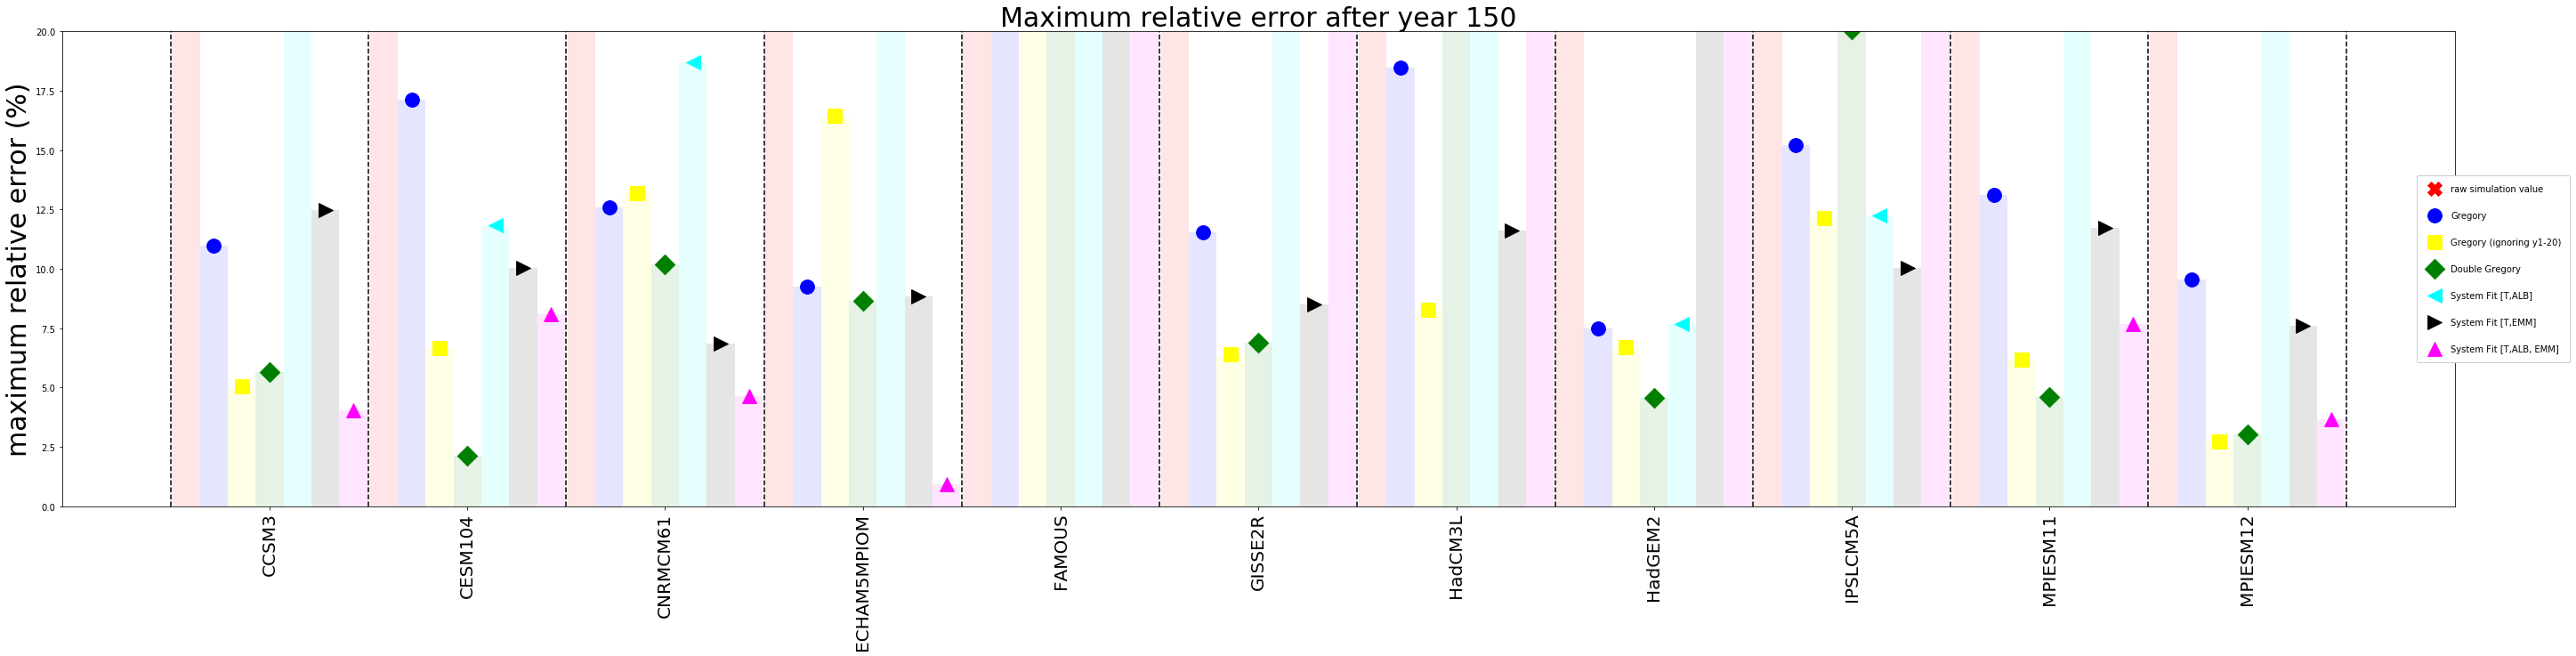

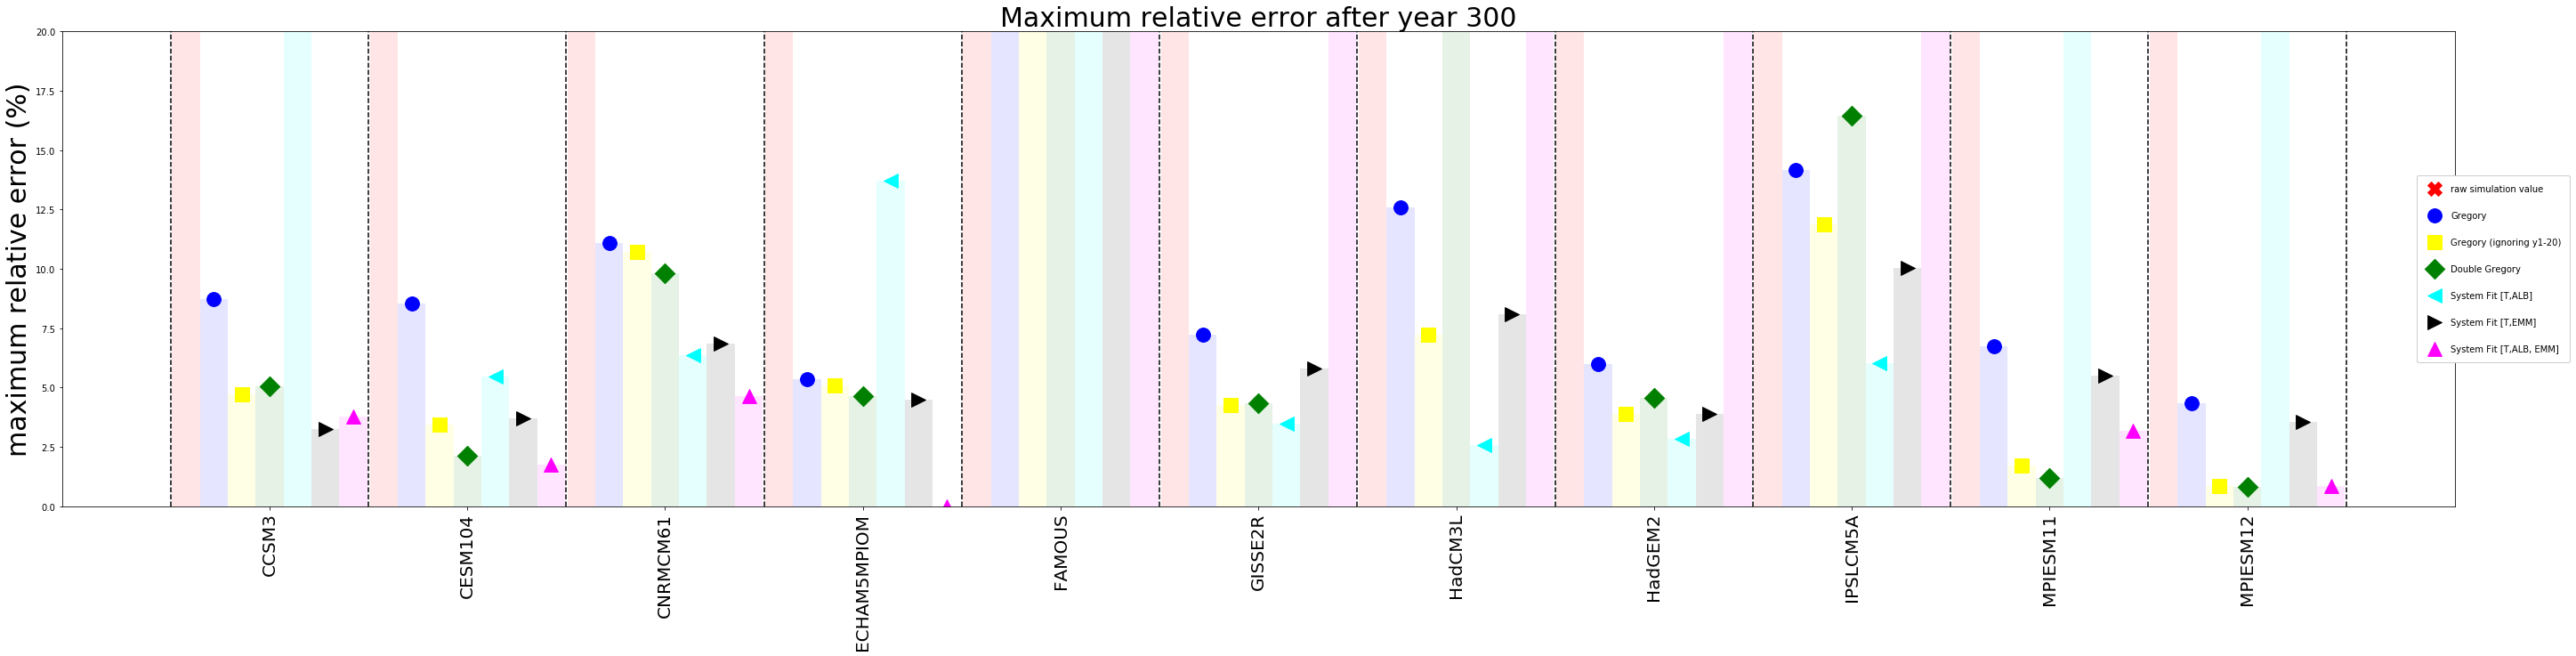

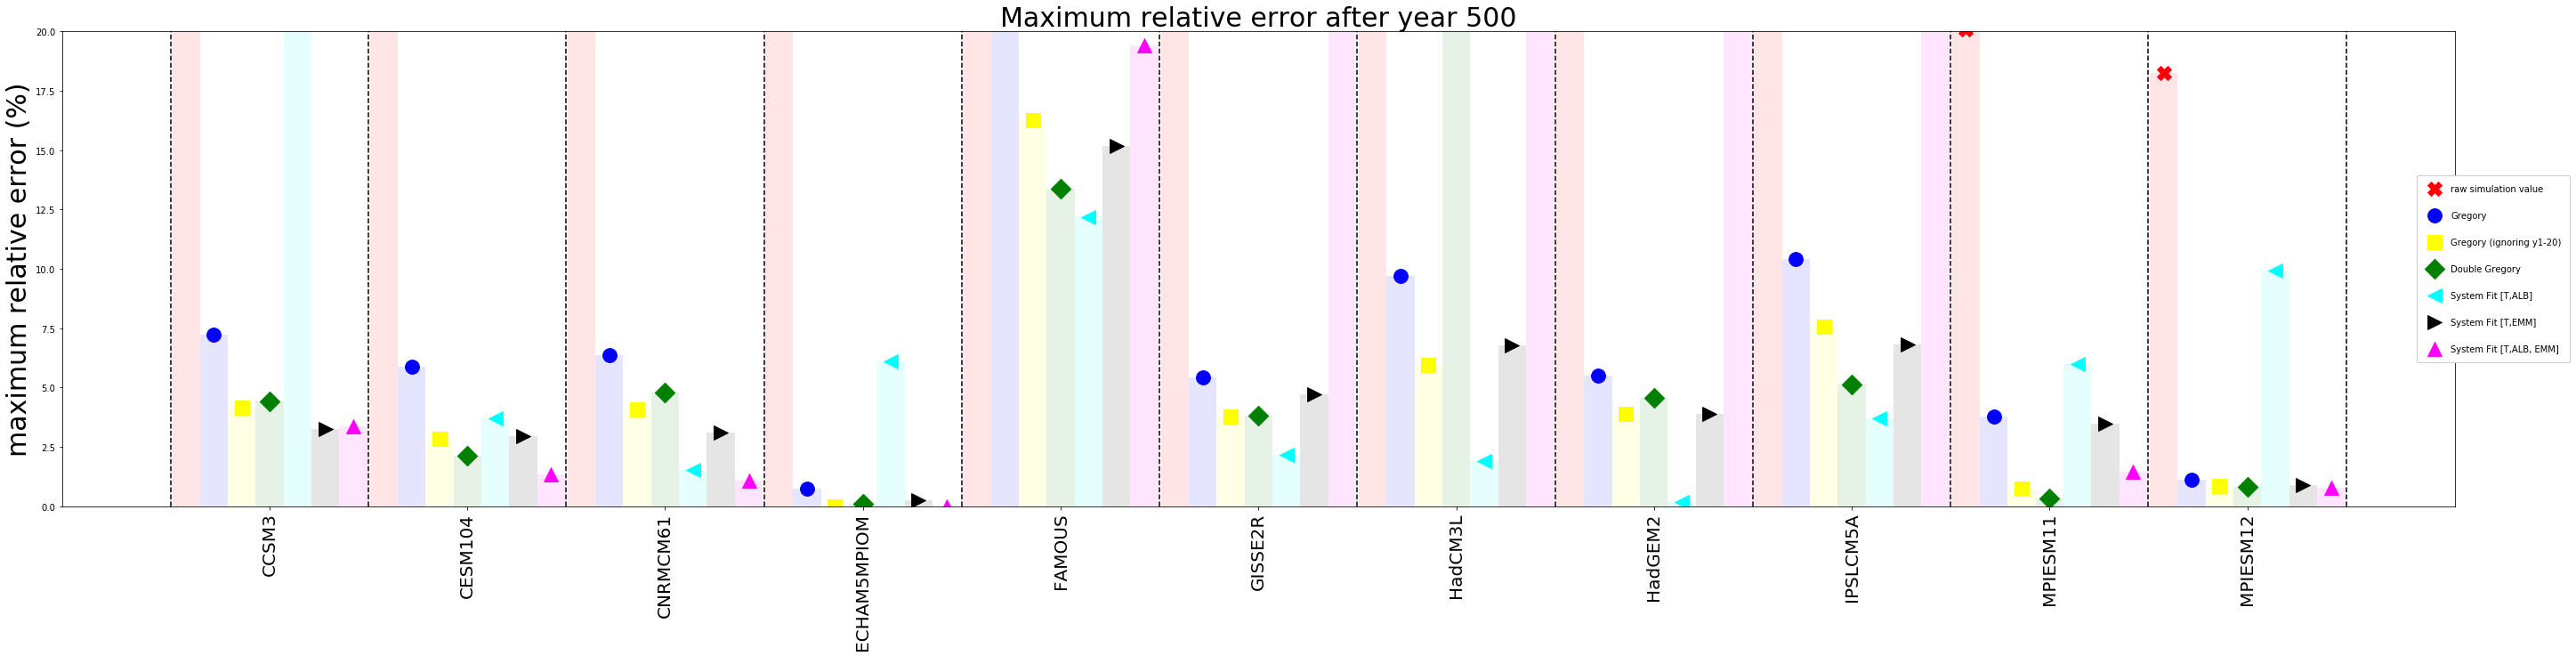

In [7]:
# Figure options
width = 0.141 # Based on 7 estimation techniques (= 1/7)
x_width = 1 # for scaling
bar_alpha = 0.10 # shading of bars
s_marker = 250 # size of markers

# Loop over all times in comparison times
for i,time in enumerate(comparison_times):

    # Figure initialisation
    fig = plt.figure(figsize = (40,10))
    ax = fig.add_subplot(111)
    
    names = [] # For x-labels
    ind1 = 0 # tracker for tracking number of models

    # Loop over all models
    for name in comparison_errors.keys():
        names.append(name)
        ind2 = -3 # index for tracking number of technique; should start at number of (techniques-1)/2 for nice figures
        
        # Loop over all techniques
        # NOTE: times 100 since we are now displaying the percentage!
        for technique in comparison_errors[name]:
            ax.bar(ind1*x_width + ind2 * width, 100*technique['rem_err'][i], width, color = technique['color'], alpha = bar_alpha)
            if(ind1 == 0):
                ax.scatter(ind1*x_width + ind2 * width, 100*technique['rem_err'][i], color = technique['color'], marker = technique['marker'], s = s_marker, label = technique['name'])
            else: # To prevent double legend entries
                ax.scatter(ind1*x_width + ind2 * width, 100*technique['rem_err'][i], color = technique['color'], marker = technique['marker'], s = s_marker)
            ind2 = ind2 + 1
        ind1 = ind1 + 1
        
    plt.ylim([0,20])
    
    ind = np.arange(ind1)*x_width # number of models; for make-up of figure
    
    ax.set_xticks(ind)
    ax.set_xticklabels(names)
    
    ax.legend(loc = 'center right', bbox_to_anchor = (1.05, 0.5), fancybox = True, ncol = 1, framealpha = 1, facecolor = 'inherit', borderpad = 1, labelspacing = 2)
    
    ax.vlines(ind - 0.5*x_width, 0, 100, linestyles = 'dashed', colors = "k")
    ax.vlines(ind[-1] + 0.5*x_width, 0, 100, linestyles = 'dashed', colors = 'k')
    
    plt.ylabel('maximum relative error (%)', fontsize=30)
    plt.xticks(fontsize=20, rotation = 90);
    plt.tight_layout()
    plt.title('Maximum relative error after year ' + str(time), fontsize=30)
    
    plt.savefig('longrunmip_figs/' + 'remaining_error_after_year_' + str(time) + '.png', bbox_inches = 'tight')
    
    try:
        if not os.path.isdir('longrunmip_figs/tikz'):
            os.mkdir('longrunmip_figs/tikz')
        tikzplotlib.save('longrunmip_figs/tikz/remaining_error_after_year_' + str(time) + '.tikz')
    except:
        pass

<h3> Bar plots only for RAW, Gregory, Gregory (ignoring y1-20) and best of system fit techniques</h3>

In [8]:
## GENERAL DATA COLLECTION FUNCTION

def collect_data(comparison_errors, i):
    # Input: 
    # comparison_errors array
    # index i that we are currently interested in
    # Output:
    # four arrays with errors (minimum for system fit techniques) and array of names

    ## Now we hard code the methods and put data in arrays
    raw_err = [] # error of raw methods
    greg_err = [] # error of greg methods
    greg20_err = [] # error of gregory (ignoring y1-20) methods
    sysfit_err = [] # minimum of error of system fit techniques methods
    names = [] # names of the models
    
    ### Collect data
    for name in comparison_errors.keys():
        names.append(name)
        buf = []
        for technique in comparison_errors[name]: # Note: times 100 because percentage are shown
            if technique['name'] == 'raw simulation value':
                raw_err.append(100*technique['rem_err'][i])
            elif technique['name'] == 'Gregory':
                greg_err.append(100*technique['rem_err'][i])
            elif technique['name'] == 'Gregory (ignoring y1-20)':
                greg20_err.append(100*technique['rem_err'][i])
            elif 'System Fit' in technique['name']: # Then we have a system fit method
                buf.append(100*technique['rem_err'][i])
        sysfit_err.append(np.min(buf))
        
    return raw_err, greg_err, greg20_err, sysfit_err, names

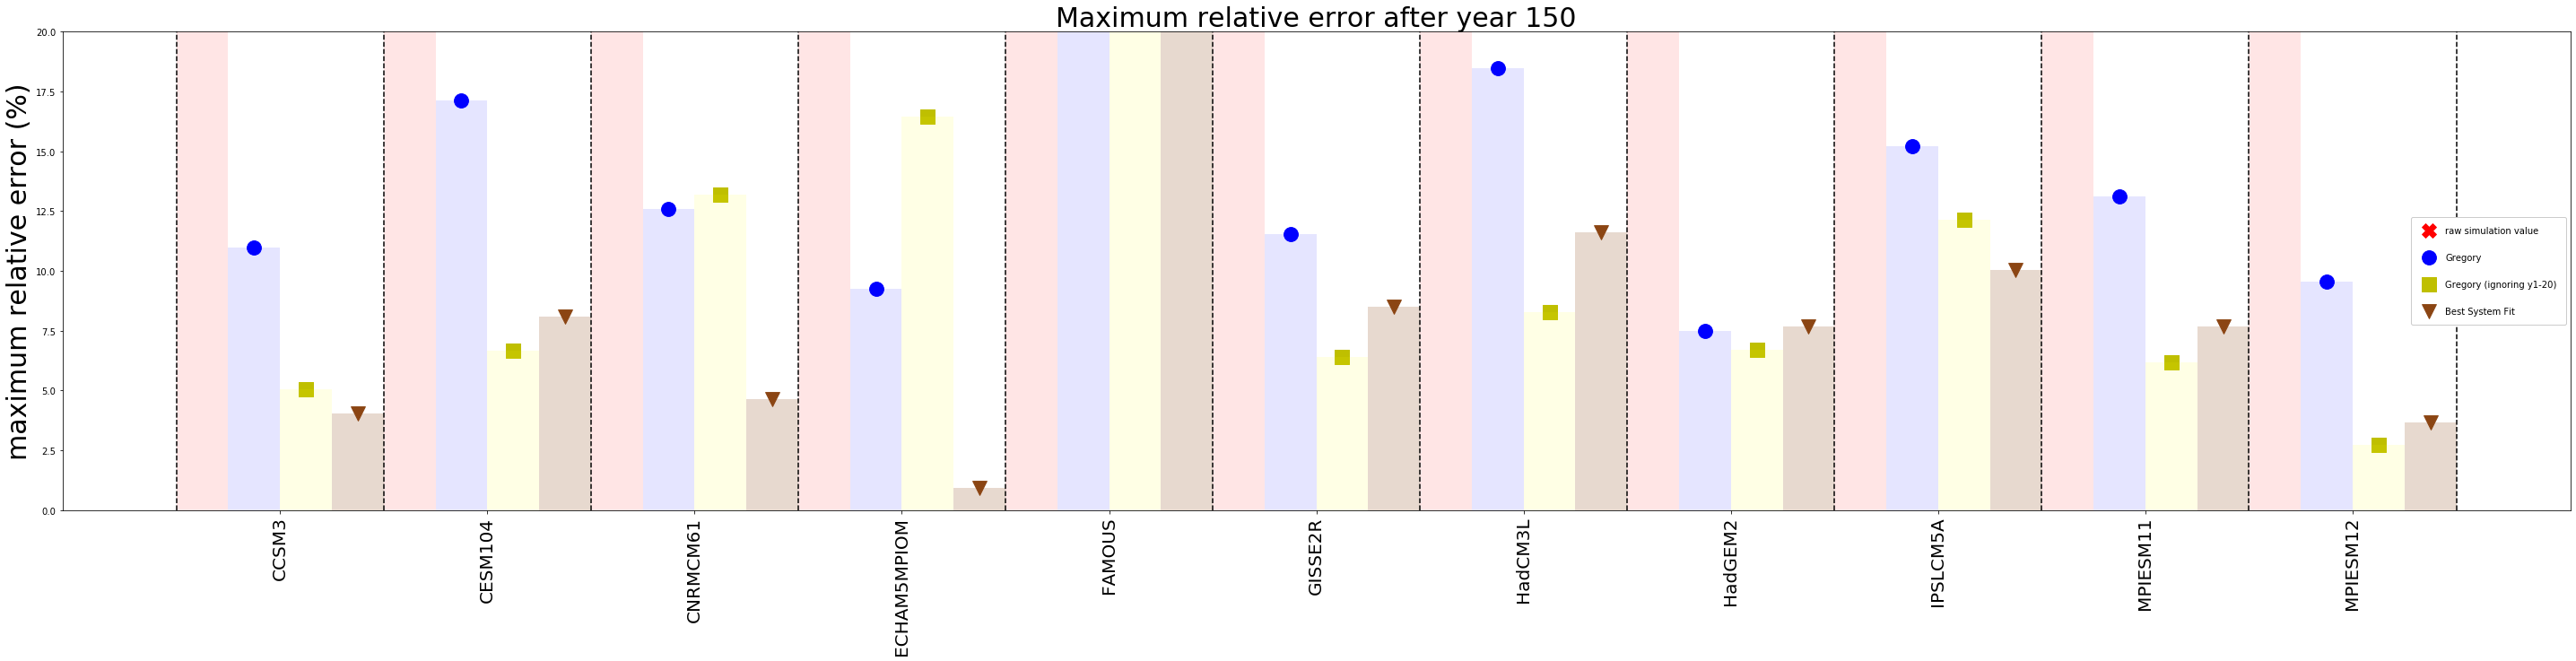

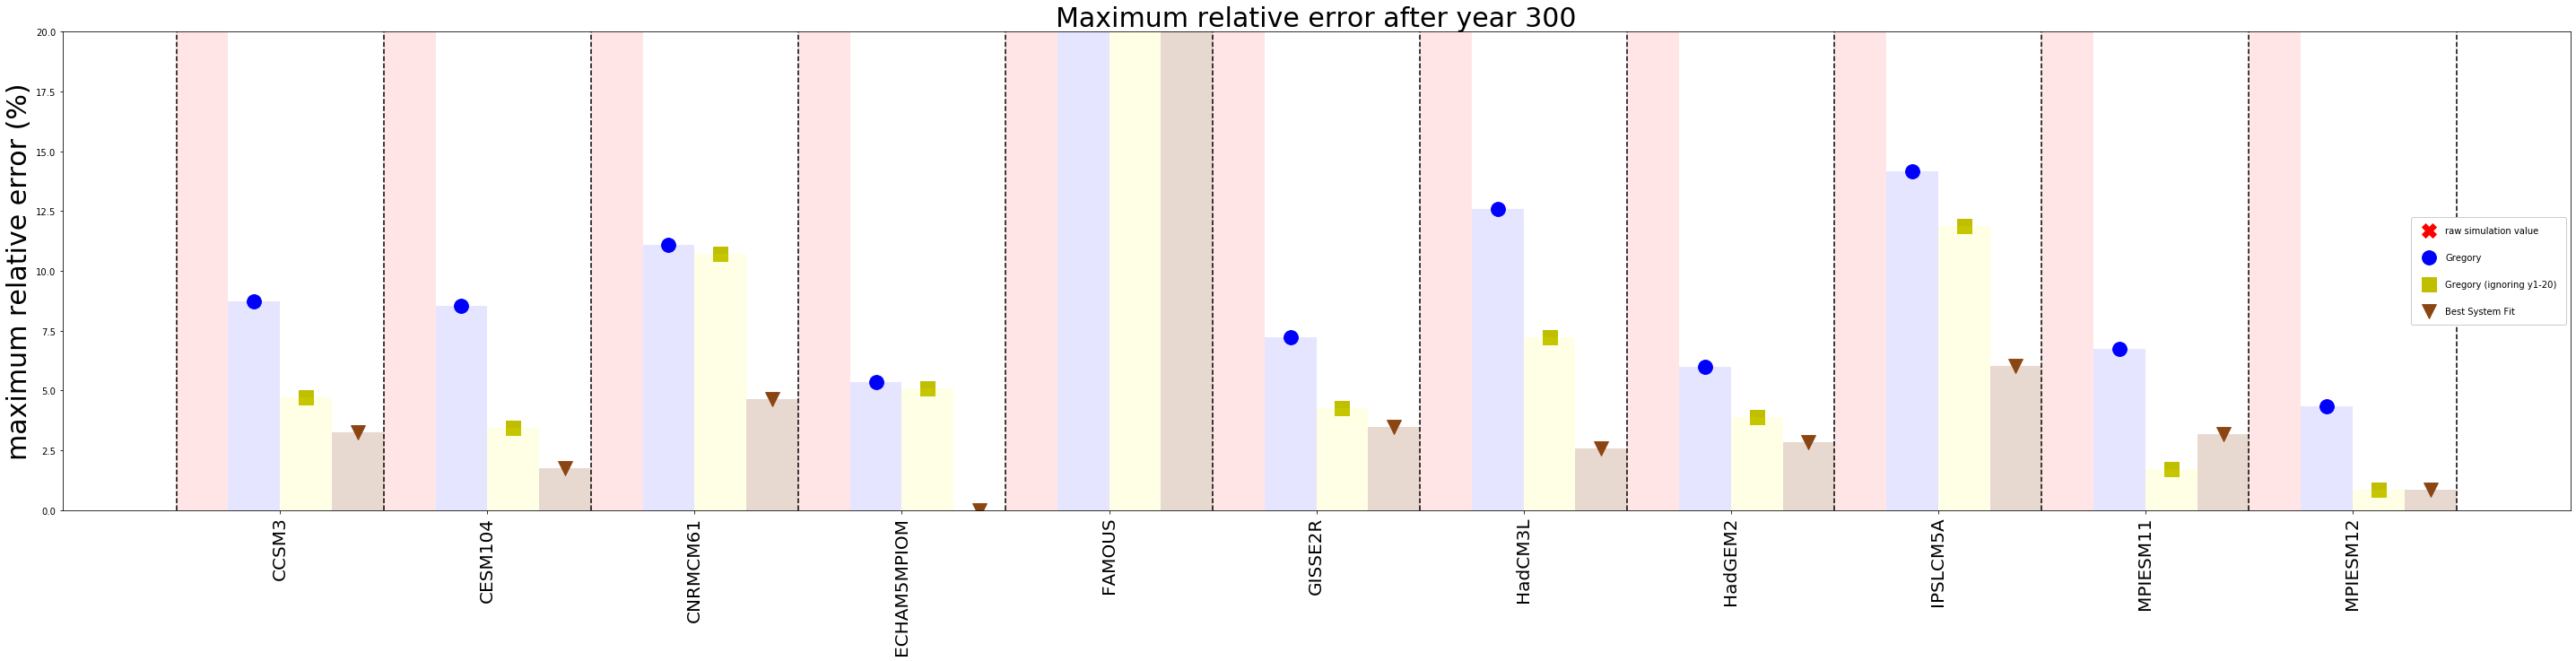

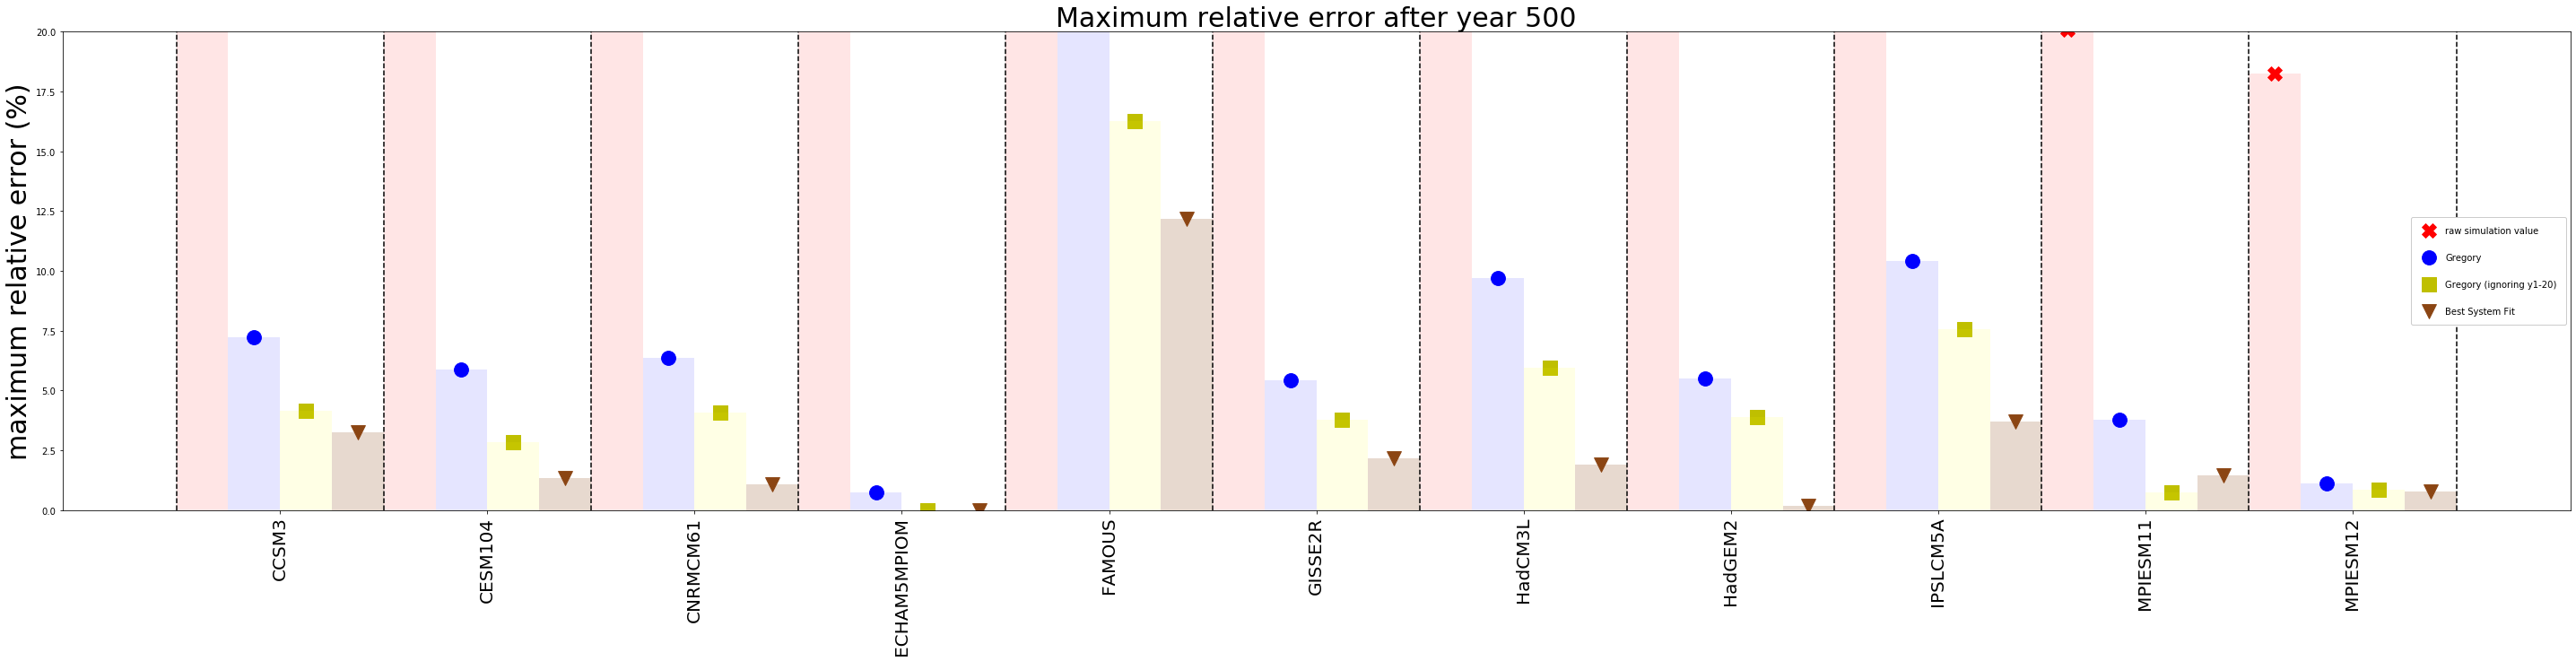

In [9]:
# Figure options
width = 0.25 # Based on 4 estimation techniques (= 1/4)
x_width = 1 # for scaling
bar_alpha = 0.10 # shading of bars
s_marker = 250 # size of markers


# Loop over all times in comparison_times
for i, time in enumerate(comparison_times):

    ### Collect data
    raw_err, greg_err, greg20_err, sysfit_err, names = collect_data(comparison_errors, i)
    
    
    ### Make Bar plot
    fig = plt.figure(figsize = (40,10))
    ax = fig.add_subplot(111)
    
    ind = np.arange(len(names)) * x_width
    
    # Make the bars
    ax.bar(ind - 1.5*width, raw_err, width, color = 'red', alpha = bar_alpha )
    ax.bar(ind - 0.5*width, greg_err, width, color = 'blue', alpha = bar_alpha )
    ax.bar(ind + 0.5*width, greg20_err, width, color = 'yellow', alpha = bar_alpha )
    ax.bar(ind + 1.5*width, sysfit_err, width, color = 'saddlebrown', alpha = 2*bar_alpha )
    
    # Make the markers
    ax.scatter(ind - 1.5*width, raw_err, marker = 'X', s = s_marker, color = 'r', label = 'raw simulation value')
    ax.scatter(ind - 0.5*width, greg_err, marker = 'o', s = s_marker, color = 'b', label = 'Gregory')
    ax.scatter(ind + 0.5*width, greg20_err, marker = 's', s = s_marker, color = 'y', label = 'Gregory (ignoring y1-20)')
    ax.scatter(ind + 1.5*width, sysfit_err, marker = 'v', s = s_marker, color = 'saddlebrown', label = 'Best System Fit')
    
    plt.ylim([0, 20])
    ax.set_xticks(ind)
    ax.set_xticklabels( names )
            
    ax.legend(loc = 'center right', bbox_to_anchor = (1, 0.5), fancybox = True, ncol = 1, framealpha = 1, facecolor = 'inherit', borderpad = 1, labelspacing = 2)
    
    ax.vlines(ind - 0.5*x_width, 0, 100, linestyles = 'dashed', colors = "k")
    ax.vlines(ind[-1] + 0.5*x_width, 0, 100, linestyles = 'dashed', colors = 'k')
    
    plt.ylabel('maximum relative error (%)', fontsize=30)
    plt.xticks(fontsize=20, rotation = 90);
    plt.tight_layout()
    plt.title('Maximum relative error after year ' + str(time), fontsize=30)
    
    plt.savefig('longrunmip_figs/' + 'remaining_error_after_year_' + str(time) + '_compact.png', bbox_inches = 'tight')
    
    try:
        if not os.path.isdir('longrunmip_figs/tikz'):
            os.mkdir('longrunmip_figs/tikz')
        tikzplotlib.save('longrunmip_figs/tikz/remaining_error_after_year_' + str(time) + '_compact.tikz')
    except:
        pass
    

<h3> Scatter plot: Greg vs System Fit </h3>

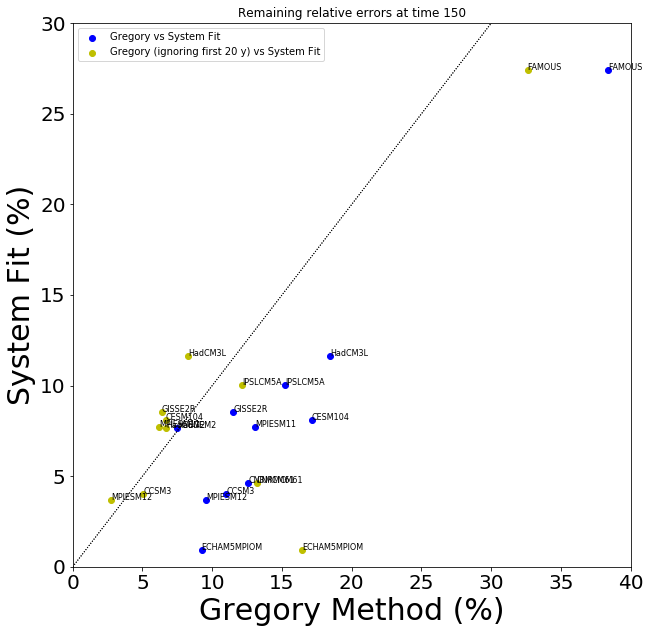

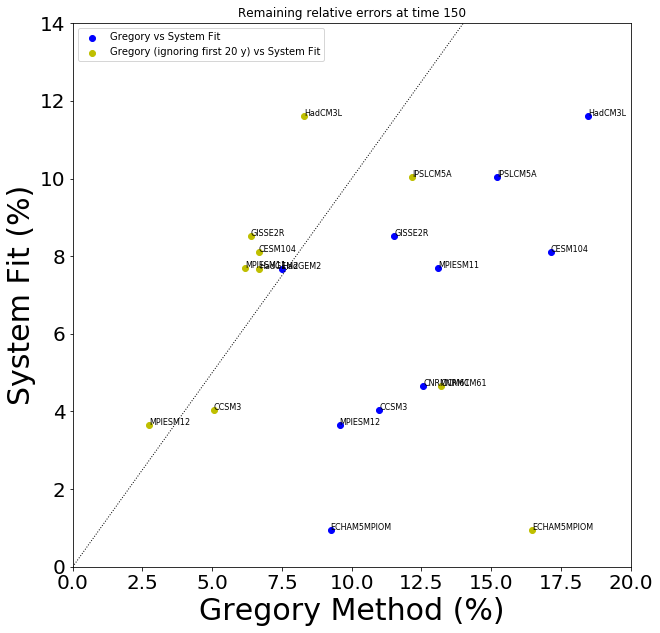

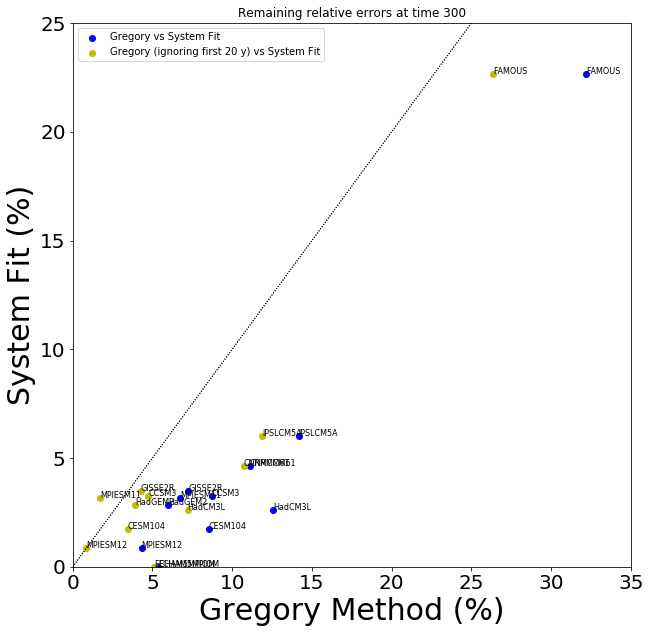

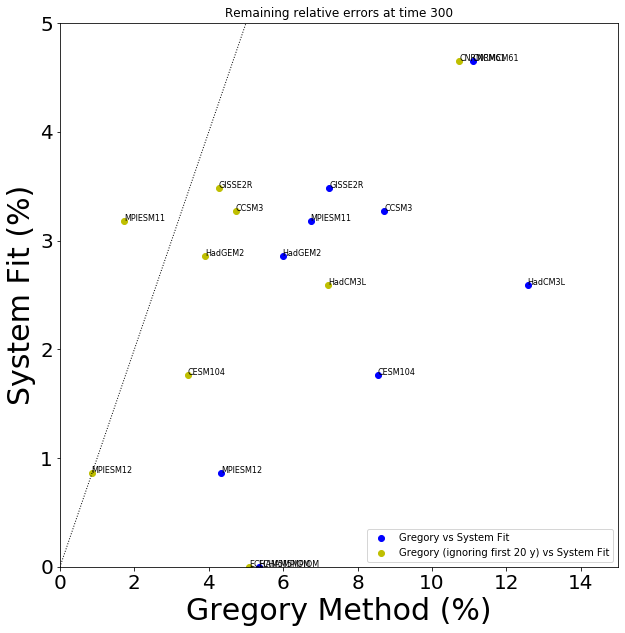

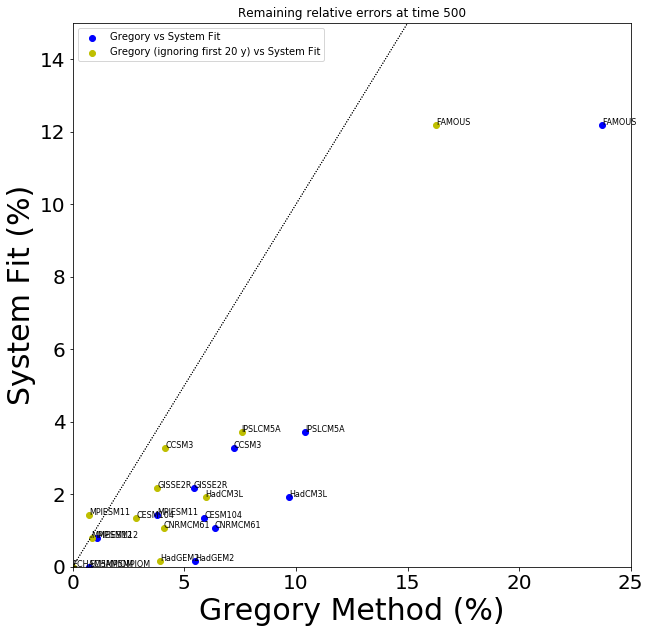

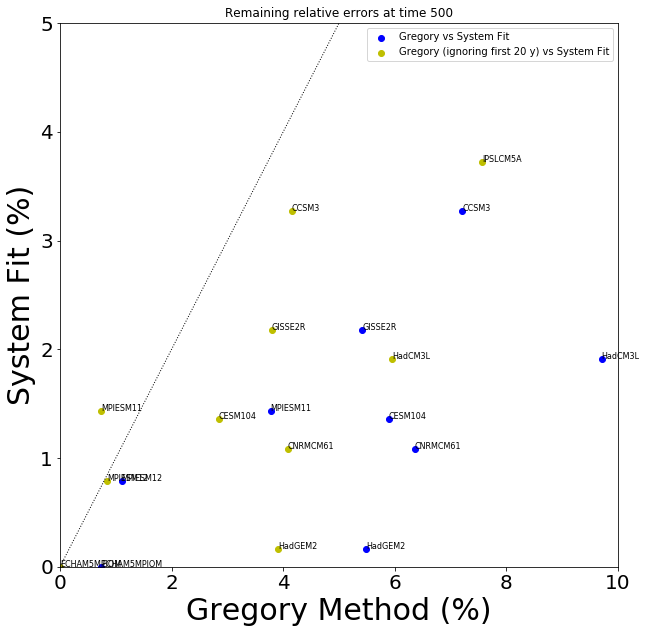

In [10]:
# Loop over all times in comparison_times
for i, time in enumerate(comparison_times):

    ### Collect data
    raw_err, greg_err, greg20_err, sysfit_err, names = collect_data(comparison_errors, i)
    
    
    ### Make general figure
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    
    # Hand-coded nice viewing windows
    if i == 0:
        ymax = 30
        xmax = 40
    elif i == 1:
        ymax = 25
        xmax = 35
    elif i == 2:
        ymax = 15
        xmax = 25
        
    plt.scatter(greg_err,sysfit_err, c='b', label = 'Gregory vs System Fit')
    for j, txt in enumerate(names):
        if greg_err[j] < xmax and sysfit_err[j] < ymax:
            plt.annotate(txt, (greg_err[j],sysfit_err[j]), size = 8)
        
    plt.scatter(greg20_err,sysfit_err, c='y', label = 'Gregory (ignoring first 20 y) vs System Fit')
    for j, txt in enumerate(names):
        if greg20_err[j] < xmax and sysfit_err[j] < ymax:
            plt.annotate(txt, (greg20_err[j],sysfit_err[j]), size = 8)
    plt.plot([0, 35],[0, 35], 'k:', linewidth = 1)

    plt.ylim([0,ymax])
    plt.xlim([0,xmax])
    
    plt.legend()
    
    plt.plot([0, 35],[0, 35], 'k:', linewidth = 1)
    plt.ylabel('System Fit (%)', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Gregory Method (%)', fontsize=30)
    plt.title('Remaining relative errors at time ' + str(time))
    
    

    
    
    plt.savefig('longrunmip_figs/' + 'technique_comparison_' + str(time) + '.png', bbox_inches = 'tight')
    try:
        if not os.path.isdir('longrunmip_figs/tikz'):
            os.mkdir('longrunmip_figs/tikz')
        tikzplotlib.save('longrunmip_figs/tikz/technique_comparison_' + str(time) + '.tikz')
    except:
        pass
    
    ### Zoomed-in version
    fig = plt.figure(figsize = (10,10) )
    ax = fig.add_subplot(111)
    
   # Hand-coded nice viewing windows
    if i == 0:
        ymax = 14
        xmax = 20
    elif i == 1:
        ymax = 5
        xmax = 15
    elif i == 2:
        ymax = 5
        xmax = 10
    
    plt.scatter(greg_err,sysfit_err, c='b', label = 'Gregory vs System Fit')
    for j, txt in enumerate(names):
        if greg_err[j] < xmax and sysfit_err[j] < ymax:
            plt.annotate(txt, (greg_err[j],sysfit_err[j]), size = 8)
        
    plt.scatter(greg20_err,sysfit_err, c='y', label = 'Gregory (ignoring first 20 y) vs System Fit')
    for j, txt in enumerate(names):
        if greg20_err[j] < xmax and sysfit_err[j] < ymax:
            plt.annotate(txt, (greg20_err[j],sysfit_err[j]), size = 8)
    plt.plot([0, 35],[0, 35], 'k:', linewidth = 1)

    plt.ylim([0,ymax])
    plt.xlim([0,xmax])
    
    
         
    plt.legend()
    plt.ylabel('System Fit (%)', fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Gregory Method (%)', fontsize=30)
    plt.title('Remaining relative errors at time ' + str(time))
    
        
        
    plt.savefig('longrunmip_figs/' + 'technique_comparison_zoomed_' + str(time) + '.png', bbox_inches = 'tight')
    try:
        if not os.path.isdir('longrunmip_figs/tikz'):
            os.mkdir('longrunmip_figs/tikz')
        tikzplotlib.save('longrunmip_figs/tikz/technique_comparison_zoomed_' + str(time) + '.tikz')
    except:
        pass
    